# Import Library

In [113]:
import mnist

In [114]:
import mlx.core as mx
import mlx.nn as nn
import mlx.optimizers as optim

from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

# GAN Architecture

## Generator 👨🏻‍🎨

In [115]:
def GenBlock(in_dim:int,out_dim:int):
   
    return nn.Sequential(
        nn.Linear(in_dim,out_dim),
        nn.BatchNorm(out_dim),
        nn.ReLU()
    )

In [116]:
class Generator(nn.Module):

    def __init__(self, z_dim:int = 10, im_dim:int = 784, hidden_dim: int =128):
        super(Generator, self).__init__()
        # Build the neural network
        self.gen = nn.Sequential(
            GenBlock(z_dim, hidden_dim),
            GenBlock(hidden_dim, hidden_dim * 2),
            GenBlock(hidden_dim * 2, hidden_dim * 4),
            GenBlock(hidden_dim * 4, hidden_dim * 8),


            nn.Linear(hidden_dim * 8,im_dim),
            nn.Sigmoid()
        )
        
    def __call__(self, noise):

        return self.gen(noise)

In [117]:
gen = Generator(100)
gen

Generator(
  (gen): Sequential(
    (layers.0): Sequential(
      (layers.0): Linear(input_dims=100, output_dims=128, bias=True)
      (layers.1): BatchNorm(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (layers.2): ReLU()
    )
    (layers.1): Sequential(
      (layers.0): Linear(input_dims=128, output_dims=256, bias=True)
      (layers.1): BatchNorm(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (layers.2): ReLU()
    )
    (layers.2): Sequential(
      (layers.0): Linear(input_dims=256, output_dims=512, bias=True)
      (layers.1): BatchNorm(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (layers.2): ReLU()
    )
    (layers.3): Sequential(
      (layers.0): Linear(input_dims=512, output_dims=1024, bias=True)
      (layers.1): BatchNorm(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (layers.2): ReLU()
    )
    (layers.4): Linear(input_dims=1024, output_dims=784, bias=True

In [118]:
def get_noise(n_samples, z_dim):
    return np.random.randn(n_samples,z_dim)

## Discriminator 🕵🏻‍♂️

In [119]:
def DisBlock(in_dim:int,out_dim:int):
    return nn.Sequential(
        nn.Linear(in_dim,out_dim),
        nn.LeakyReLU(negative_slope=0.2)
    )

In [120]:
class Discriminator(nn.Module):

    def __init__(self,im_dim:int = 784, hidden_dim:int = 128):
        super(Discriminator, self).__init__()

        self.disc = nn.Sequential(
            DisBlock(im_dim, hidden_dim * 4),
            DisBlock(hidden_dim * 4, hidden_dim * 2),
            DisBlock(hidden_dim * 2, hidden_dim),

            nn.Linear(hidden_dim,1),
        )
        
    def __call__(self, noise):

        return self.disc(noise)

In [121]:
disc = Discriminator()
disc

Discriminator(
  (disc): Sequential(
    (layers.0): Sequential(
      (layers.0): Linear(input_dims=784, output_dims=512, bias=True)
      (layers.1): LeakyReLU()
    )
    (layers.1): Sequential(
      (layers.0): Linear(input_dims=512, output_dims=256, bias=True)
      (layers.1): LeakyReLU()
    )
    (layers.2): Sequential(
      (layers.0): Linear(input_dims=256, output_dims=128, bias=True)
      (layers.1): LeakyReLU()
    )
    (layers.3): Linear(input_dims=128, output_dims=1, bias=True)
  )
)

# Model Training 🏋🏻‍♂️

In [122]:
# Set your parameters
criterion = nn.losses.binary_cross_entropy
n_epochs = 200
z_dim = 64
display_step = 500
batch_size = 128
lr = 0.00001

In [123]:
gen = Generator(z_dim)
mx.eval(gen.parameters())
gen_opt = optim.Adam(learning_rate=lr)

disc = Discriminator()
mx.eval(disc.parameters())
disc_opt = optim.Adam(learning_rate=lr)

KeyboardInterrupt: 

## Losses

In [ ]:
def disc_loss(gen, disc, real, num_images, z_dim):
    noise =  mx.array(get_noise(num_images, z_dim))
    fake_images = gen(noise)
    
    fake_disc = disc(fake_images)
    
    fake_labels = mx.zeros((fake_images.shape[0],1))
    fake_loss = nn.losses.binary_cross_entropy(fake_disc,fake_labels,with_logits=True)
    
    real_disc = disc(real)
    real_labels = mx.ones((real.shape[0],1))

    # print('Shapes.....',real_disc.shape,real_labels.shape)
    real_loss = nn.losses.binary_cross_entropy(real_disc,real_labels)

    disc_loss = (fake_loss + real_loss) / 2

    return disc_loss

In [ ]:
def gen_loss(gen, disc, num_images, z_dim):

    noise = mx.array(get_noise(num_images, z_dim))
    fake_images = gen(noise)
    
    fake_disc = disc(fake_images)

    fake_labels = mx.ones((fake_images.shape[0],1))
    
    gen_loss = nn.losses.binary_cross_entropy(fake_disc,fake_labels,with_logits=True)

    return gen_loss

In [105]:
train_images, _, test_images, _ = map(
    mx.array, getattr(mnist, 'mnist')()
)

In [106]:
def batch_iterate(batch_size:int, ipt:list):
    perm = mx.array(np.random.permutation(len(ipt)))
    for s in range(0, ipt.size, batch_size):
        ids = perm[s : s + batch_size]
        yield ipt[ids]

### show batch of images

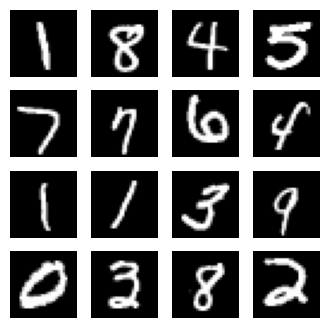

In [ ]:
for X in batch_iterate(16, train_images):
    fig,axes = plt.subplots(4, 4, figsize=(4, 4))

    for i, ax in enumerate(axes.flat):
        img = mx.array(X[i]).reshape(28,28)
        ax.imshow(img,cmap='gray')
        ax.axis('off')
    break

In [ ]:
batch_size = 8
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0
error = False

D_loss_grad = nn.value_and_grad(disc, disc_loss)
G_loss_grad = nn.value_and_grad(gen, gen_loss)


for epoch in range(10):
  
    # Dataloader returns the batches
    # for real in tqdm(batch_iterate(batch_size, train_images)):
    
    for real in tqdm(train_images):

    
        # real = real.reshape(-1)
        
        # Flatten the batch of real images from the dataset
        
        # plt.imshow(real[0].reshape(28,28))
        # print(len(real))
        # break
                
        D_loss,D_grads = D_loss_grad(gen, disc, real, batch_size, z_dim)

        # Update optimizer
        disc_opt.update(disc, D_grads)
        
        # Update gradients
        
        G_loss,G_grads = G_loss_grad(gen, disc, batch_size, z_dim)
        
        # Update optimizer
        gen_opt.update(gen, G_grads)
        
        # Update gradients


        # # Keep track of the average discriminator loss
        # mean_discriminator_loss += disc_loss.item() / display_step

        # # Keep track of the average generator loss
        # mean_generator_loss += gen_loss.item() / display_step

        # ### Visualization code ###
        # if cur_step % display_step == 0 and cur_step > 0:
        #     print(f"Step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
        #     fake_noise = get_noise(cur_batch_size, z_dim, device=device)
        #     fake = gen(fake_noise)
        #     show_tensor_images(fake)
        #     show_tensor_images(real)
        #     mean_generator_loss = 0
        #     mean_discriminator_loss = 0
        # cur_step += 1


  0%|          | 139/60000 [00:00<01:22, 726.53it/s]

real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape , 

  1%|          | 307/60000 [00:00<01:14, 801.44it/s]

real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape , 

  1%|          | 471/60000 [00:00<01:13, 808.99it/s]

real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape , 

  1%|          | 633/60000 [00:00<01:14, 800.05it/s]

real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape , 

  1%|▏         | 794/60000 [00:01<01:16, 778.34it/s]

real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape , 

  2%|▏         | 949/60000 [00:01<01:18, 747.52it/s]

real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape , 

  2%|▏         | 1098/60000 [00:01<01:20, 733.90it/s]

real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape , 

  2%|▏         | 1240/60000 [00:01<01:28, 660.48it/s]

real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape , 

  2%|▏         | 1307/60000 [00:01<01:29, 656.89it/s]

real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape , 

  2%|▏         | 1438/60000 [00:02<01:36, 608.91it/s]

real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape , 

  3%|▎         | 1561/60000 [00:02<01:36, 603.59it/s]

real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape , 

  3%|▎         | 1683/60000 [00:02<01:40, 582.79it/s]

real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape , 

  3%|▎         | 1799/60000 [00:02<01:45, 552.37it/s]

real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape , 

  3%|▎         | 1915/60000 [00:02<01:46, 543.12it/s]

real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape , 

  3%|▎         | 2026/60000 [00:03<01:46, 543.94it/s]

real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape , 

  4%|▎         | 2142/60000 [00:03<01:43, 560.25it/s]

real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape , 

  4%|▍         | 2257/60000 [00:03<01:45, 545.45it/s]

real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape , 

  4%|▍         | 2365/60000 [00:03<01:51, 518.84it/s]

real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape , 

  4%|▍         | 2472/60000 [00:03<01:53, 506.74it/s]

real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape , 

  4%|▍         | 2575/60000 [00:04<01:53, 504.04it/s]

real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape , 

  4%|▍         | 2626/60000 [00:04<02:02, 469.09it/s]

real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape , 

  5%|▍         | 2781/60000 [00:04<01:55, 494.90it/s]

real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape , 

  5%|▍         | 2831/60000 [00:04<01:56, 490.73it/s]

real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape , 

  5%|▍         | 2928/60000 [00:04<02:10, 438.99it/s]

real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape , 

  5%|▌         | 3023/60000 [00:05<02:05, 453.50it/s]

real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape , 

  5%|▌         | 3118/60000 [00:05<02:03, 460.44it/s]

real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape , 

  5%|▌         | 3211/60000 [00:05<02:06, 449.22it/s]

real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape , 

  6%|▌         | 3302/60000 [00:05<02:16, 416.36it/s]

real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape , 

  6%|▌         | 3391/60000 [00:05<02:12, 426.27it/s]

real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape , 

  6%|▌         | 3479/60000 [00:06<02:13, 423.14it/s]

real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape , 

  6%|▌         | 3564/60000 [00:06<02:17, 411.69it/s]

real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape , 

  6%|▌         | 3648/60000 [00:06<02:20, 401.16it/s]

real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape ,  (784,)
real shape , 

  6%|▌         | 3662/60000 [00:54<14:01, 66.96it/s] 


KeyboardInterrupt: 

In [90]:
disc_loss(gen, disc, real, batch_size, z_dim)

Shapes..... (1,) (784, 1)


ValueError: Inputs shape (1,) does not match targets shape (784, 1).

In [86]:
real.shape[0]

784

In [47]:
real.shape

(8, 784)

In [ ]:
real.reshape((-1,len(real))).shape